# Error Propagation for SED Modelling
This script is intended to be used to perform error propogation with monte carlo simulations. The intent of this script will be to use a sample galaxy sed from cigale and create variations of through pertubing it with random noise. 

In [91]:
# Import all required packages
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath
import seaborn as sns

# refresh

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# Load in all of the filters
# Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')


pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)

In [93]:
full_cdfs_ids = pd.read_csv('datasets/zfourge/full_CDFS_ids.csv')
full_cosmos_ids = pd.read_csv('datasets/zfourge/full_COSMOS_ids.csv')
full_uds_ids = pd.read_csv('datasets/zfourge/full_UDS_ids.csv')


In [94]:

# Using dataframes is wildly inefficient. 
# A most robust approach would be to use only the 2 columns we are interested in, specified in the function call
# and then read these in as numpy arrays


def get_n_seds(df, n, field, restframe=False, all=False):
    # Select n galaxies
    
    df_list = []
    names = []
    redshifts = []
    if all==False:
        selected_galaxies = df.sample(n)
    else: 
        selected_galaxies = df
        
    # Reset the index
    selected_galaxies = selected_galaxies.reset_index(drop=True)
    
    # name 
    gal_name = selected_galaxies['id'].astype(str)
    
    # field
    gal_field = field#selected_galaxies['field'].astype(str)
    
    
    names = gal_field + '_' + gal_name
    gal_redshift = selected_galaxies['zpk'].astype(float)

    # Now we will read in the fits files for these galaxies

    for i in range(len(selected_galaxies)):
        path = 'datasets\\full_zfourge_decomposed\\'+ str(gal_field).lower() +'_best_models_fits\\'
        name = str(gal_name[i])+'_best_model.fits'

        galaxy_path = os.path.join(path, name)
        with fits.open(galaxy_path) as data:
            df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder())
        
        # Convert to angstroms
        df['wavelength'] = df['wavelength']*10

        if restframe:
            df['Snu'] = df['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            # F_nu currently has a frequency dependence, convert to nuFnu by multiplying the the frequency associated
            # with the wavelength, as we are in angstroms, we can use the formula c = f*lambda
            
            
            # This should prevent any issues, but check
            freq = (3*10**18)/df['wavelength'] # in Hz
            # multiply the Snu * nu to get nuSnu
            df['nuSnu'] = df['Snu']*freq
            # Restframe the values of wavelength
            df['wavelength'] = df['wavelength'] / (1 + gal_redshift[i]) # we redshift the values of of wavelength
            # now calculate a new frequency, based on the new wavelength
            freq = (3*10**18)/df['wavelength'] # in Hz
            # divide the nuSnu by the new frequency to get the restframed values
            df['Snu'] = df['nuSnu']/freq
            
            # Convert flux values
            df['Flambda'] = df['Snu']*(3*10**-5)/(df['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        else:
            # Convert flux values
            df['Snu'] = df['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            df['Flambda'] = df['Snu']*(3*10**-5)/(df['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        
            
            
        redshift_Val = gal_redshift[i]
        redshifts.append(redshift_Val)        
        
        

        
        # For simplicity, just create some extra columns
        df['lambda (Angstroms)'] = df['wavelength']
        df['Total Flux (erg/s/cm^2/Angstrom)'] = df['Flambda']
        
        
        
        df_list.append(df)
        
        
        plt.loglog(df['wavelength'], df['Flambda'])
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Flux (Fnu)')
    #plt.xlim(1e3, 1e5)
    plt.ylim(1e-30, 1e-2)
    plt.title('SED of galaxies')
    plt.legend()
    plt.show()
    
    print(len(df_list))
    
    return df_list, names, redshifts


In [95]:
np.random.seed(42)

def get_n_seds(df, n, field, restframe=False, all=False):

    # Select n galaxies (only the necessary columns)
    if all:
        selected_indices = np.arange(len(df))
    else:
        selected_indices = np.random.choice(len(df), n, replace=False)

    names = []
    redshifts = []
    df_list = []
    
    print(selected_indices)
    
    for i in selected_indices:
        name = f"{field}_{df['id'][i]}"

        redshift = df['zpk'][i]
        names.append(name)
        redshifts.append(redshift)

        # Load FITS file (using only the necessary columns)
        path = f'datasets\\full_zfourge_decomposed\\{field.lower()}_best_models_fits\\'
        file = f"{df['id'][i]}_best_model.fits"

        with fits.open(os.path.join(path, file)) as data:
            wavelength = data[1].data['wavelength'] * 10  # Convert to Angstroms
            fnu = data[1].data['Fnu']

        # Convert and rest-frame data (in-place operations for efficiency)
        snu = fnu * 1e-3  # milliJansky to Jansky
        flambda = snu * 3e-5 / wavelength**2

        if restframe:
            wavelength /= (1 + redshift)
            freq = 3e18 / wavelength
            snu = snu * freq / freq  # Avoid division by zero
            flambda = snu * 3e-5 / wavelength**2

        # Create DataFrame (only with necessary columns)
        df_galaxy = pd.DataFrame({
            'lambda (Angstroms)': wavelength,
            'Total Flux (erg/s/cm^2/Angstrom)': flambda
        })

        df_list.append(df_galaxy)
        
        # plotting, keep if needed
        #plt.loglog(df_galaxy['lambda (Angstroms)'], df_galaxy['Total Flux (erg/s/cm^2/Angstrom)'])

    # Plotting (only once after the loop)
    # plt.xlabel('Wavelength (Angstroms)')
    # plt.ylabel('Flux (Fnu)')
    # plt.ylim(1e-30, 1e-2)
    # plt.title('SED of galaxies')
    # plt.legend()
    # plt.show()

    return df_list, names, redshifts


In [96]:
# Get one SED for testing from the CDFS field
test_sed_list, names, redshifts = get_n_seds(full_cdfs_ids, 1, 'CDFS', restframe=True, all=False)

[2227]


In [97]:
# Now we can safely select the test sed

test_sed = test_sed_list[0]
test_name = names[0]
test_redshift = redshifts[0]


In [98]:
# Print info
print(f"Name: {test_name}")
print(f"Redshift: {test_redshift}")
test_sed.head()


Name: CDFS_14819
Redshift: 0.6559


,lambda (Angstroms),Total Flux (erg/s/cm^2/Angstrom)
0,10.000000,0.0
1,11.481536,0.0
2,13.182567,0.0
3,15.135612,0.0
4,17.378008,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


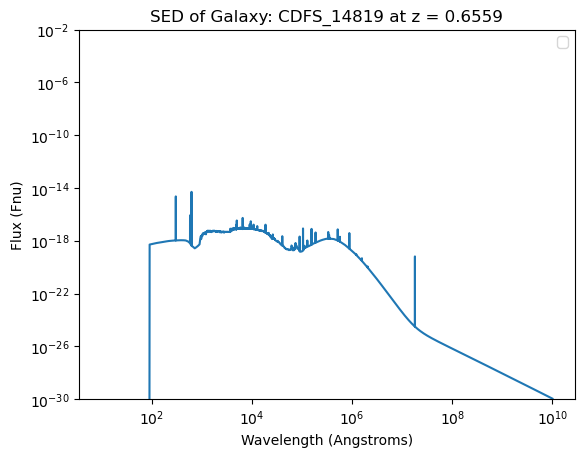

In [99]:
# We can plot the SED with the redshift information
plt.loglog(test_sed['lambda (Angstroms)'], test_sed['Total Flux (erg/s/cm^2/Angstrom)'])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (Fnu)')
plt.ylim(1e-30, 1e-2)
plt.title("SED of Galaxy: " + test_name + " at z = " + str(test_redshift))
plt.legend()
plt.show()


In [101]:
# Now we can attempt to read in the CDFS fits file and extract the associated data
cdfs_df =read_zfourge_data('CDFS','datasets/zfourge')

c:\Users\Titan\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Titan\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Titan\Documents\GitHub\HonoursResearchProject\carf.py:1098: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, 'mag_V'] = flux_to_mag(df['V'])
c:\Users\Titan\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Titan\Documents\GitHub\HonoursResearchProject\carf.py:1099: Performanc

In [105]:
# Get the associated row containing the information for the test galaxy
test_galaxy = cdfs_df[cdfs_df['id'] == test_name]

In [106]:
test_galaxy

,recno,id,xpos,ypos,RAJ2000,DEJ2000,SE,isoArea,FKsap,e_FKsap,...,lmass,mag_U,mag_V,mag_J,e_mag_U,e_mag_V,e_mag_J,UV,VJ,field
14886,14819,CDFS_14819,1508.53,4055.993,53.221203,-27.806158,2,536.0,36.53167,0.07205,...,10.11,23.910508,22.506983,21.100254,27.474377,26.988906,26.336186,1.403525,1.406729,CDFS


In [107]:
cdfs_df

,recno,id,xpos,ypos,RAJ2000,DEJ2000,SE,isoArea,FKsap,e_FKsap,...,lmass,mag_U,mag_V,mag_J,e_mag_U,e_mag_V,e_mag_J,UV,VJ,field
0,1,CDFS_1,4078.527,203.090,53.100105,-27.966728,19,5484.0,73.39300,0.26373,...,11.56,22.128170,20.068596,18.985397,24.137389,23.296963,23.137208,2.059573,1.083200,CDFS
1,2,CDFS_2,6292.975,55.927,52.995632,-27.972803,2,315.0,9.56143,0.25146,...,9.05,24.007524,23.108191,22.593727,27.869360,28.547027,27.633753,0.899333,0.514464,CDFS
2,3,CDFS_3,1791.772,51.199,53.207989,-27.973034,2,375.0,10.82121,0.26373,...,10.42,24.823751,23.283146,21.851087,27.891747,26.678404,26.468798,1.540605,1.432059,CDFS
3,4,CDFS_4,4181.315,176.410,53.095257,-27.967840,3,1060.0,76.36145,0.26373,...,11.83,19.589616,17.675879,18.227869,inf,inf,inf,1.913737,-0.551990,CDFS
4,5,CDFS_5,5997.950,48.860,53.009548,-27.973110,0,219.0,26.52806,0.25146,...,10.51,21.702808,21.837879,22.405160,27.903116,28.089700,28.370834,-0.135071,-0.567281,CDFS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30906,30907,CDFS_30907,4150.499,7668.344,53.096783,-27.655676,0,124.0,3.93497,0.23131,...,10.08,24.231164,23.969626,23.632093,27.952808,25.379935,28.327743,0.261538,0.337533,CDFS
30907,30908,CDFS_30908,3050.447,7621.582,53.148533,-27.657625,0,195.0,10.53820,0.20227,...,10.56,26.596601,24.346522,22.435589,inf,inf,inf,2.250080,1.910933,CDFS
30908,30909,CDFS_30909,4385.049,7547.789,53.085751,-27.660698,0,18.0,0.74274,0.22289,...,9.60,25.601854,25.571331,24.955310,30.083650,30.589700,31.567715,0.030524,0.616021,CDFS
30909,30910,CDFS_30910,3221.845,7527.777,53.140469,-27.661535,0,36.0,0.95773,0.19657,...,9.46,26.265728,25.488033,25.269030,29.331073,30.001668,30.857724,0.777694,0.219003,CDFS


In [ ]:
# Print each of the column names
for col in cdfs_df.columns:
    print(col)